In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
# import seaborn as sns
import random
import os
import sys
import time
import datetime
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig,OutputType
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sktime.datasets import load_from_ucr_tsv_to_dataframe
from sktime.datasets import load_from_tsfile
import neptune.new as neptune
import datetime
import uuid
import pickle as pkl
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from InceptionTime import InceptionBlock,Inception,Reshape,Flatten


c:\Users\nati\Desktop\Implementations\ImplementationsVenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# preprocessing steps:
# 1. reading the data
# 2. expanding dim 
# 3. convert target to numbers
# 4. generate synthetic data. with control of the amount of original data that the generator model uses.
# 5. save the generated data in folder structure 
X_train,y_train = load_from_tsfile(r"C:\Users\nati\Desktop\Implementations\FinalProject\Datasets\BasicMotions\BasicMotions_TRAIN.ts")
X_test,y_test = load_from_tsfile(r"C:\Users\nati\Desktop\Implementations\FinalProject\Datasets\BasicMotions\BasicMotions_TEST.ts")

In [8]:
def preprocess_dgan(df:pd.DataFrame,sequence_length:int):
    df = df.copy(deep=True)
    data = []
    for row in df.iterrows():
        for col in df.columns:
            data.append([row[1][col]])
    data = np.array(data)
    data = data.reshape((df.shape[0], sequence_length, df.shape[1]))
    return data

In [9]:
X_train = preprocess_dgan(X_train,100)
X_test= preprocess_dgan(X_test,100)



In [10]:
class TimeSeriesDataset(Dataset):    
    def __init__(self, X, y, transform=None, trarget_transform=None):
        self.X = X 
        self.y = y
        self.transform = transform
        self.target_transform = trarget_transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            y = self.target_transform(y)
        return torch.tensor(X), torch.tensor(y)

In [11]:
class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim=31, hidden_dim=256, num_layers=1, output_dim=5, dropout=0):
        '''
        input_dim = number of features at each time step 
        hidden_dim = number of features produced by each LSTM cell (in each layer)
        num_layers = number of LSTM layers
        output_dim = number of classes (number of activities)
        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, X):
        _, (h_n, c_n) = self.lstm(X)  # (h_0, c_0) default to zeros
        out = self.fc(h_n[-1,:,:])
        out = self.softmax(out)
        return out

In [12]:
class GRU_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU_Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        out, _ = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out
    

In [14]:
# Split the data into train and test sets
def split_dataset_by_label(X, y):
    splits = {}
    unique_labels = np.unique(y)
    for label in unique_labels:
        splits[label] = {'X': np.array(X[y == label]), 'y': np.array(y[y == label])}
    return splits

def get_divisor(num:int):
    divisors = []
    for i in range(1, num + 1):
        if num % i == 0:
            divisors.append(i)
    return divisors
DGAN_param = {  'epochs': 1,
                'attribute_noise_dim': 10,
                'feature_noise_dim': 10, 
                'attribute_num_layers': 3, 
                'attribute_num_units': 100, 
                'feature_num_layers':  1, 
                'feature_num_units':100, 
                'use_attribute_discriminator': True, 
                'normalization': False, 
                'apply_feature_scaling': True, 
                'apply_example_scaling': True, 
                'binary_encoder_cutoff': 150, 
                'forget_bias': False, 
                'gradient_penalty_coef': 10.0, 
                'attribute_gradient_penalty_coef':10.0, 
                'attribute_loss_coef': 1.0, 
                'generator_learning_rate':  0.001, 
                'generator_beta1':  0.5, 
                'discriminator_learning_rate': 0.001, 
                'discriminator_beta1': 0.5, 
                'attribute_discriminator_learning_rate':  0.001, 
                'attribute_discriminator_beta1': 0.5, 
                'batch_size':  1024, 
                'discriminator_rounds': 1, 
                'generator_rounds': 1,
                'mixed_precision_training': False}
def train_dgan(data:np.ndarray, DGAN_param:dict, Experiment_param:dict):
    run = neptune.init_run(
    project="astarteam/FinalProject",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
    )  # your credentialscredentials

    run['Experiment_param'] = Experiment_param
    run["DGAN_param"] = DGAN_param

    model = DGAN(DGANConfig(
        max_sequence_len=data.shape[1],
        sample_len=random.choice(get_divisor(data.shape[1])[-3:]), 
        batch_size=min(1000, data.shape[0]),
        apply_feature_scaling=DGAN_param['apply_feature_scaling'],
        apply_example_scaling=DGAN_param['apply_example_scaling'],
        use_attribute_discriminator=DGAN_param['use_attribute_discriminator'],
        generator_learning_rate=DGAN_param['generator_learning_rate'],
        discriminator_learning_rate=DGAN_param['discriminator_learning_rate'],
        epochs=DGAN_param['epochs'],
        gradient_penalty_coef = DGAN_param['gradient_penalty_coef'],
    ))

    model.train_numpy(
        data,
        feature_types=[OutputType.CONTINUOUS] * data.shape[2],
    )
    time.sleep(2)
    run.stop()
    return model

def train_generator_per_label(splitted_data:pd.DataFrame, DGAN_param:dict, Experiment_param:dict):
    models = {}
    for label in splitted_data.keys():
        print(f"Training generator for label {label}")
        X = splitted_data[label]['X']
        DGAN_param['label'] = label
        model = train_dgan(X, DGAN_param, Experiment_param)
        models[label] = model
    return models

def generate_data_per_label(models, num_samples, Experiment_param):
    generated_data = {}
    for label in models.keys():
        print(f"Generating data for label {label}")
        generated_data[label] = models[label].generate_numpy(num_samples)[1]
    concatenated_data = {'X':np.concatenate([generated_data[label] for label in generated_data.keys()]),
                'y':np.concatenate([np.array([label]*num_samples) for label in generated_data.keys()])}
    np.save(f'''dataset/{Experiment_param['Dataset name']}/{Experiment_param['Experiment_id']}''', concatenated_data)
    # df.to_csv(f'''dataset/{DGAN_param['Dataset name']}/{DGAN_param['Experiment_id']}.csv''', index=False)
    return generated_data,concatenated_data

def create_data_loaders(X,y,n_splits:int = 1, validation_size:float=0.2):
    ssf = StratifiedShuffleSplit(n_splits=n_splits, test_size=validation_size)
    train_ind, test_ind = next(ssf.split(X,y))
    train_dataloader = DataLoader(TimeSeriesDataset(X[train_ind],y[train_ind]),batch_size=20,shuffle=True)
    validation_dataloader = DataLoader(TimeSeriesDataset(X[test_ind],y[test_ind]),batch_size=20,shuffle=True)
    return train_dataloader, validation_dataloader

def map_label_int(y):    
    label_to_int = {label: i for i, label in enumerate(np.unique(y))}
    int_to_label = {i: label for label, i in label_to_int.items()}
    y_int = np.array([label_to_int[label] for label in y])
    return label_to_int, int_to_label, y_int

def train_loop(data_loader, model,device,loss_fn,optimizer,print_every_n=200):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.type(torch.LongTensor)
        y = y.to(device)
        pred = model(X.float())
        # print(f'Preds : {pred.argmax(1)}')
        # print(f'GT : {y}')
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss, current = loss.item(), batch*len(X)
        if batch%print_every_n==0:
            print(f'loss={loss:.3f}, {current} / {size}')

    train_loss /= num_batches
    train_acc = tp/size    
    print(f'train accuracy = {train_acc}, val_loss = {train_loss:2f}')
    return train_loss,train_acc

def validation_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    val_loss=0
    tp=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            pred = model(X.float())
            val_loss += loss_fn(pred,y).item()
            tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        
    val_loss /= num_batches
    val_acc = tp/size
    print(f'validation accuracy = {val_acc}, val_loss = {val_loss:2f}')
    return val_loss,val_acc

In [15]:
split_data = split_dataset_by_label(X_train,y_train)
# TODO: add params to train generator so we can track the dataset generating process  
Experiment_param ={'experiment state':'data generation',
                'Experiment_id': f'{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_{uuid.uuid4().hex}',
                'Dataset name':'BasicMotions', # Dataset name most be as generated dataset dir name. it will be used while saving the generated data  
                'usage of original data': 80, }

DGAN_param = {  'epochs': 1,
                'attribute_noise_dim': 10,
                'feature_noise_dim': 10, 
                'attribute_num_layers': 3, 
                'attribute_num_units': 100, 
                'feature_num_layers':  1, 
                'feature_num_units':100, 
                'use_attribute_discriminator': True, 
                'normalization': False, 
                'apply_feature_scaling': True, 
                'apply_example_scaling': True, 
                'binary_encoder_cutoff': 150, 
                'forget_bias': False, 
                'gradient_penalty_coef': 10.0, 
                'attribute_gradient_penalty_coef':10.0, 
                'attribute_loss_coef': 1.0, 
                'generator_learning_rate':  0.001, 
                'generator_beta1':  0.5, 
                'discriminator_learning_rate': 0.001, 
                'discriminator_beta1': 0.5, 
                'attribute_discriminator_learning_rate':  0.001, 
                'attribute_discriminator_beta1': 0.5, 
                'batch_size':  1024, 
                'discriminator_rounds': 1, 
                'generator_rounds': 1,
                'mixed_precision_training': False}

models = train_generator_per_label(split_data, DGAN_param, Experiment_param)
generated_data,concatenated_data = generate_data_per_label(models, 20, DGAN_param, Experiment_param)
label_to_int, int_to_label, concatenated_data['y'] = map_label_int(concatenated_data['y'])
train_dataloader, validation_dataloader = create_data_loaders(concatenated_data['X'],concatenated_data['y'],n_splits=1, validation_size=0.2)

Training generator for label badminton
https://app.neptune.ai/astarteam/FinalProject/e/FIN-111
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


ValueError: multiprocessing_context option should specify a valid start method in ['spawn'], but got multiprocessing_context='fork'

In [2]:
import yaml

def read_yaml_config(file_path):
    with open(file_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
            return config
        except yaml.YAMLError as exc:
            print(exc)
            return None

config_path = 'config.yaml'
config_data = read_yaml_config(config_path)

if config_data:
    print("Database Host:", config_data['database']['host'])
    print("Database Port:", config_data['database']['port'])
    print("Log Level:", config_data['settings']['log_level'])
    print("Max Retries:", config_data['settings']['max_retries'])


Database Host: localhost
Database Port: 5432
Log Level: INFO
Max Retries: 5


In [23]:
output_dim = len(np.unique(y))
lr = 0.001
best_acc = 0
best_loss = np.inf
model = GRU_Classifier(input_size=6, hidden_size=64, num_layers=2, num_classes=4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
save_each_epoch = True

In [205]:
output_dim = len(np.unique(y))
lr = 0.001
best_acc = 0
best_loss = np.inf
model = LSTM_Classifier(num_layers=2,input_dim = 6,hidden_dim=64,output_dim=output_dim,dropout=0.3)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True
Experiment_param['model type'] = 'LSTM' # model type: LSTM, GRU, inception time, transformer
run_param = {"epochs": 20,
            "patience":5,
            "batch_size": 20,
            "learning_rate": lr, 
            "criterion":"CrossEntropyLoss",
            "optimizer": "Adam"}

In [14]:
def train_and_log(epochs,patience,train_dataloader,validation_dataloader,model,device,criterion,optimizer,save_each_epoch, run_param,Experiment_param):
    run = neptune.init_run(
    project="astarteam/FinalProject",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentialscredentials

    run["parameters"] = run_param
    Experiment_param['experiment state'] = 'pretraining'
    run['Experiment_param'] = Experiment_param


    
    best_loss = np.inf
    # define the number of epochs and early stopping patience
    for epoch in range(epochs):
        #Train
        train_loss, train_acc = train_loop(train_dataloader, model, device, criterion, optimizer)
        run["train/accuracy"].log(train_acc)
        run["train/loss"].log(train_loss)
        #Evaluate
        val_loss, val_acc = validation_loop(validation_dataloader, model, device, criterion)
        run["validation/accuracy"].log(val_acc)
        run["validation/loss"].log(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            early_stopping_counter = 0
            if save_each_epoch:
                torch.save(model.state_dict(),f'model_{epoch}.pt')
        # otherwise, increment the early stopping counter
        else:
            early_stopping_counter += 1     
        # if the early stopping counter has reached the patience, stop training
        if early_stopping_counter == patience:
            break
    time.sleep(2)
    print("Finished Training and validation, now uploading to Neptune.")
    run.stop()

In [ ]:
train_and_log(30,5,train_dataloader,validation_dataloader,model,device,criterion,optimizer,save_each_epoch)

In [ ]:
label_to_int, int_to_label, y = map_label_int(y)
og_train_dataloader, og_validation_dataloader = create_data_loaders(X,y,n_splits=1, validation_size=0.4)
train_and_log(10,5,og_train_dataloader,og_validation_dataloader,model,device,criterion,optimizer,save_each_epoch)

In [218]:
#Regular Training
output_dim = len(np.unique(y))
lr = 0.001
best_acc = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_loss = np.inf
model = LSTM_Classifier(num_layers=2,input_dim = 6,hidden_dim=64,output_dim=output_dim,dropout=0.3)
model = model
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True


In [ ]:
label_to_int, int_to_label, y = map_label_int(y)
og_train_dataloader, og_validation_dataloader = create_data_loaders(X,y,n_splits=1, validation_size=0.4)
train_and_log(25,25,og_train_dataloader,og_validation_dataloader,model,device,criterion,optimizer,save_each_epoch)

In [53]:
# Fine Tune
X.shape

(40, 100, 6)

In [73]:
sequence_length = 100
dataset_paths = glob.glob('dataset\*.ts')

for path in dataset_paths:
    # read data
    X,y = load_from_tsfile(path)
    # expand dim
    data = preprocess_dgan(X,sequence_length)
    # Map the labels to integers
    label_to_int, int_to_label, y_int = map_label_int(y)
    # train data generator and create synthetic data
    data_generator(X, y, train_size)
    # create synthetic dataset
    train_dataloader, validation_dataloader = create_dataset(X,y,n_splits, validation_size)
    # train the model over syn
    
    create_dataset(X,y,n_splits, validation_size)

    


['dataset\\BasicMotions_TEST.ts', 'dataset\\BasicMotions_TRAIN.ts']

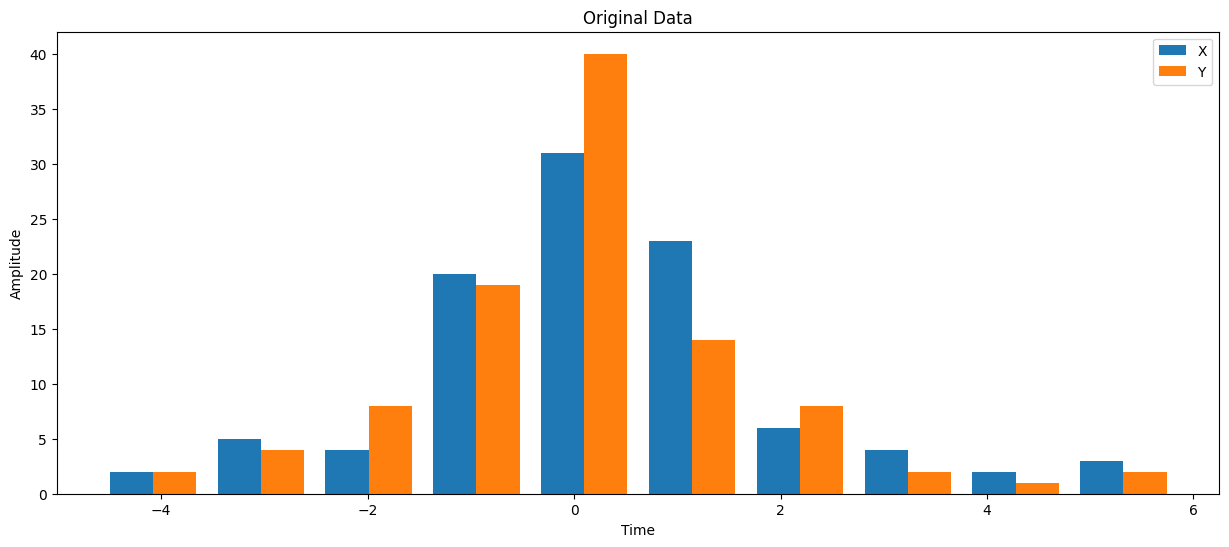

In [203]:
plt.figure(figsize=(15,6))
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.hist(X[y == 3][9,:,1:3])
plt.legend(['X','Y','Z'])

(array([[ 3.,  6., 10., 38., 29.,  6.,  4.,  2.,  2.,  0.],
        [ 0.,  0.,  2.,  4., 11., 47., 24.,  6.,  2.,  4.]]),
 array([-0.21081465, -0.09910052,  0.01261363,  0.12432777,  0.23604192,
         0.34775606,  0.45947021,  0.57118434,  0.68289846,  0.79461265,
         0.90632677]),
 <a list of 2 BarContainer objects>)

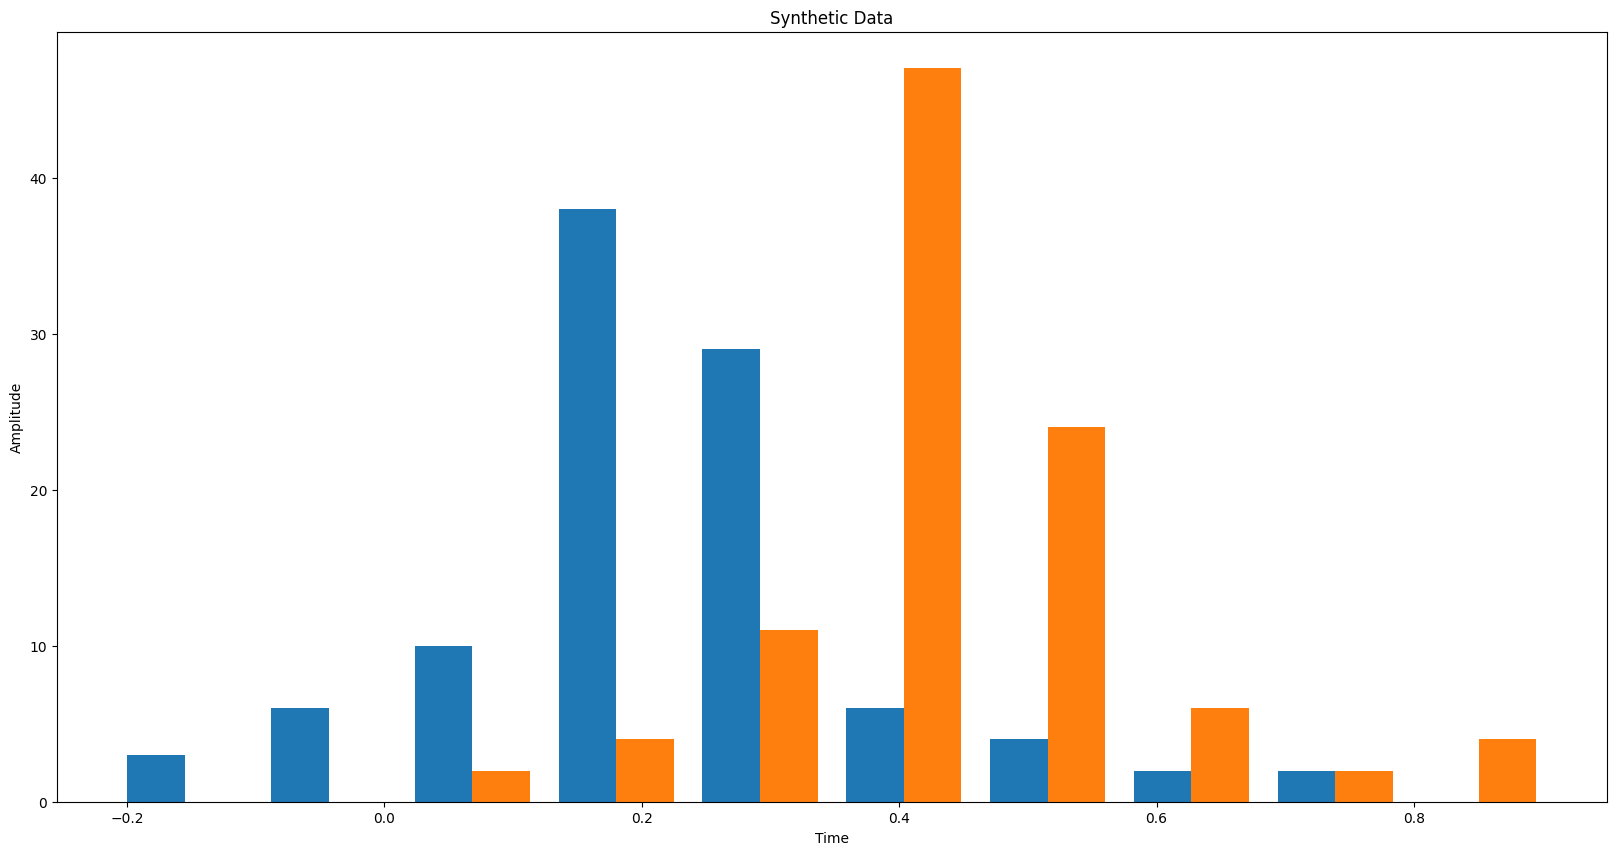

In [204]:
#plot synthetic data
plt.figure(figsize=(20,10))
plt.title('Synthetic Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.hist(concatenated_data['X'][concatenated_data['y'] == 3][100,:,1:3])
# plt.plot(concatenated_data['X'][concatenated_data['y'] == 1][11,:,3])

# plt.legend(['X','Y','Z'])